In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import os

# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 10

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data generator (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess data
# Paths for Kaggle Waste Classification Dataset
train_dir = '/content/DATASET/TRAIN'
val_dir = '/content/DATASET/TEST'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Build model using MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator
)

# Save the model in .h5 format
model.save('/content/waste_classification_model.h5')

# Download the model to your local system or Google Drive
from google.colab import files
files.download('/content/waste_classification_model.h5')

# Prediction script for Raspberry Pi with OpenCV
def predict_waste(image_path, model_path='/content/waste_classification_model.h5'):
    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Read and preprocess the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(img)[0][0]

    # Return label
    return 'Biodegradable' if prediction < 0.5 else 'Non-Biodegradable'

# Example usage for testing prediction in Colab
def test_prediction(image_path):
    label = predict_waste(image_path)
    print(f'Prediction for {image_path}: {label}')

# Test with a sample image from the test set
# Replace with an actual image path from your dataset
sample_image = '/content/DATASET/TEST/O/organic_image.jpg'  # Update with a real image path
if os.path.exists(sample_image):
    test_prediction(sample_image)
else:
    print("Sample image not found. Please provide a valid image path.")

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1437s 2s/step - accuracy: 0.8798 - loss: 0.2900 - val_accuracy: 0.8540 - val_loss: 0.3088
Epoch 2/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1476s 2s/step - accuracy: 0.9288 - loss: 0.1839 - val_accuracy: 0.8428 - val_loss: 0.3340
Epoch 3/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1439s 2s/step - accuracy: 0.9370 - loss: 0.1679 - val_accuracy: 0.8595 - val_loss: 0.3046
Epoch 4/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1458s 2s/step - accuracy: 0.9369 - loss: 0.1661 - val_accuracy: 0.8934 - val_loss: 0.2501
Epoch 5/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1440s 2s/step - accuracy: 0.9382 - loss: 0.1567 - val_accuracy: 0.8484 - val_loss: 0.3387
Epoch 6/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1491s 2s/step - accuracy: 0.9450 - loss: 0.1442 - val_accuracy: 0.8790 - val_loss: 0.2713
Epoch 7/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1450s 2s/step - accuracy: 0.9445 - loss: 0.1398 - val_accuracy: 0.8631 - val_loss: 0.3056
Epoch 8/10
706/706 ━━━━━━━━━━━━━━━━━━━━ 1465s 2s/step - accuracy: 0.9478 - loss: 0.1379 - 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sample image not found. Please provide a valid image path.


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('waste_classification_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('waste_classification_model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmprlxwy5a7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138565873063056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873065168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873065552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873065360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873063248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873066704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873067088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873067472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873067280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873064592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138565873068624

NameError: name 'history' is not defined

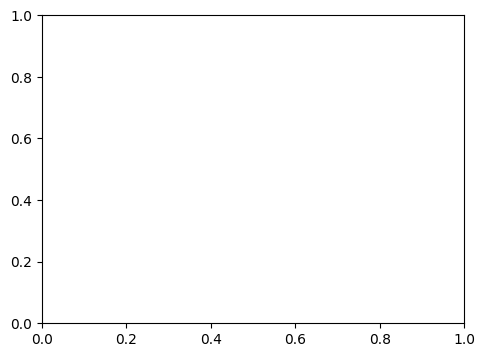

In [ ]:
# prompt: Fig. 4: Training and Validation Curves Line graphs showing training and validation
# accuracy/loss over 10 epochs.

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()